In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import Model, ureg, quantity_to_activity
from baby_run_4 import *

In [2]:
baby_model.run(7 * ureg.day)

/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


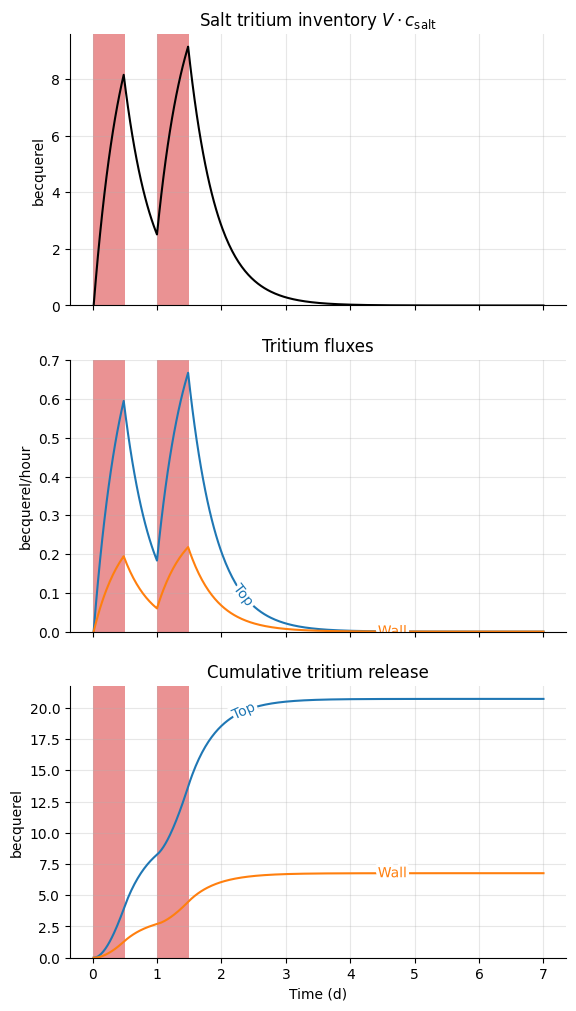

In [3]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="Top")
plt.plot(time, release_walls, label="Wall")

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="Top")
plt.plot(time, integrated_wall, label="Wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(alpha=0.3)
    labelLines(ax.get_lines(), zorder=2.5)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(
            0 * ureg.h + day * ureg.day,
            baby_model.exposure_time + day * ureg.day,
            facecolor="tab:red",
            alpha=0.5,
        )

plt.savefig("baby_run_4/basic_model_results.svg")
plt.show()


In [4]:
def replace_water(sample_activity, time, replacement_times=None):
    sample_activity_changed = np.copy(sample_activity)
    times_changed = np.copy(time)

    if replacement_times is None:
        replacement_times = [
            i + 1 for i in range(baby_model.number_days.to(ureg.day).magnitude)
        ] * ureg.day
    else:
        replacement_times = sorted(replacement_times)

    for replacement_time in replacement_times:
        indices = np.where(times_changed > replacement_time)
        # before each irradiation, make the sample activity drop to zero
        sample_activity_changed[indices] -= sample_activity_changed[indices][0]

        # insert nan value to induce a line break in plots
        if indices[0].size > 0:
            first_index = indices[0][0]
            sample_activity_changed = np.insert(
                sample_activity_changed, first_index, np.nan * ureg.Bq
            )
            times_changed = np.insert(times_changed, first_index, np.nan * ureg.day)

    return sample_activity_changed, times_changed


In [5]:
COLLECTION_VOLUME = 10 * ureg.ml
LSC_SAMPLE_VOLUME = 10 * ureg.ml


def plot_model(
    model,
    top=True,
    walls=True,
    detection_limit=0.4 * ureg.Bq,
    irradiation=True,
    replace_vials=True,
    title=True,
    subtitle=True,
    linelabel=True,
):
    plt.gca().xaxis.set_units(ureg.day)
    plt.gca().yaxis.set_units(ureg.Bq)

    if title:
        plt.gcf().text(0.08, 0.97, "Sample activity", weight="bold", fontsize=15)
    if subtitle:
        subtitle_text = [
            f"TBR = {model.TBR.to(ureg.dimensionless):.2e~P}, salt volume {model.volume.to(ureg.ml):.0f~P}, neutron rate: {model.neutron_rate:.2e~P}, irradiation time: {model.exposure_time}",
            f"collection volume: {COLLECTION_VOLUME:.0f~P}, sample volume: {LSC_SAMPLE_VOLUME:.0f~P}",
        ]
        plt.gcf().text(0.08, 0.9, s="\n".join(subtitle_text), fontsize=6.5)

    if top:
        integrated_top = quantity_to_activity(model.integrated_release_top()).to(
            ureg.Bq
        )
        sample_activity_top = integrated_top / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_top, times = replace_water(
                sample_activity_top, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_top,
            color="tab:blue",
            label="Top",
        )
    if walls:
        integrated_wall = quantity_to_activity(model.integrated_release_wall()).to(
            ureg.Bq
        )
        sample_activity_wall = integrated_wall / COLLECTION_VOLUME * LSC_SAMPLE_VOLUME
        times = model.times
        if replace_vials:
            if replace_vials is True:
                replacement_times = None
            else:
                replacement_times = replace_vials
            sample_activity_wall, times = replace_water(
                sample_activity_wall, model.times, replacement_times=replacement_times
            )
        plt.plot(
            times.to(ureg.day),
            sample_activity_wall,
            color="tab:orange",
            label="Walls",
        )

    if detection_limit:
        plt.axhline(y=detection_limit, color="tab:grey", linestyle="dashed")

    if irradiation:
        if irradiation is True:
            for day in range(model.number_days.to(ureg.day).magnitude):
                plt.axvspan(
                    0 * ureg.h + day * ureg.day,
                    model.exposure_time + day * ureg.day,
                    facecolor="tab:red",
                    alpha=0.5,
                )
        else:
            for irr in irradiation:
                plt.axvspan(
                    irr[0].to(ureg.day),
                    irr[1].to(ureg.day),
                    facecolor="tab:red",
                    alpha=0.5,
                )

    plt.xlim(left=0 * ureg.day)
    plt.ylim(bottom=0)
    # plt.yscale("log")
    if linelabel:
        labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.grid(alpha=0.5)


[<Quantity(12, 'hour')>, <Quantity(24, 'hour')>, <Quantity(36, 'hour')>, <Quantity(2, 'day')>, <Quantity(3, 'day')>, <Quantity(4, 'day')>, <Quantity(6, 'day')>]


/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


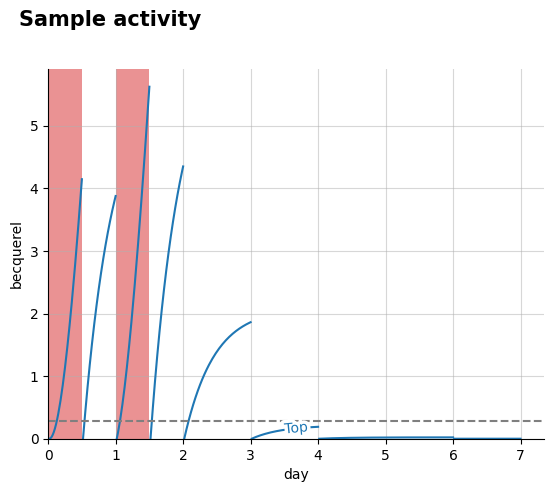

In [6]:
replacement_times = [
    irr[0] for irr in baby_model.irradiations[1:]
]  # before each irradiation

replacement_times += [
    irr[1] for irr in baby_model.irradiations
]  # after each irradiation

replacement_times.append(2 * ureg.day)  # after the last irradiation
replacement_times.append(3 * ureg.day)
replacement_times.append(4 * ureg.day)
replacement_times.append(6 * ureg.day)

replacement_times = sorted(replacement_times)

print(replacement_times)
avg_background = background_2

plot_model(
    baby_model,
    irradiation=baby_model.irradiations,
    replace_vials=replacement_times,
    walls=False,
    detection_limit=avg_background,
    subtitle=False,
)

[<Quantity(0.022, 'becquerel')>, <Quantity(0.316, 'becquerel')>, <Quantity(2.233, 'becquerel')>, <Quantity(6.096, 'becquerel')>, <Quantity(14.787, 'becquerel')>, <Quantity(18.231, 'becquerel')>, <Quantity(19.394, 'becquerel')>]
[<Quantity(12, 'hour')>, <Quantity(24, 'hour')>, <Quantity(36, 'hour')>, <Quantity(2, 'day')>, <Quantity(3, 'day')>, <Quantity(4, 'day')>, <Quantity(6, 'day')>]


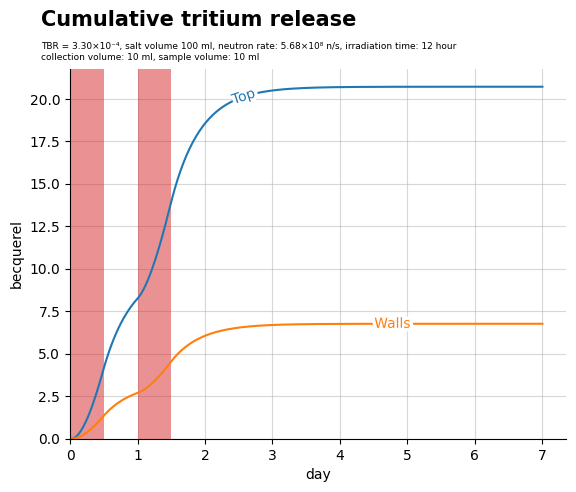

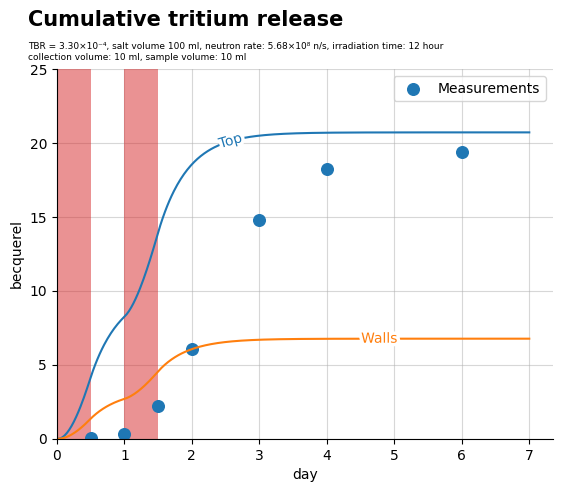

In [7]:
plot_model(
    model=baby_model,
    replace_vials=False,
    title=False,
    detection_limit=None,
    linelabel=True,
)
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_4/cumulative_tritium_release_no_exp.svg")

plt.figure()
plot_model(
    model=baby_model,
    replace_vials=False,
    title=False,
    detection_limit=None,
    linelabel=True,
)
sample_1 = vial_421 + vial_422 + vial_423 + vial_424
sample_2 = vial_431 + vial_432 + vial_433 + vial_434
sample_3 = vial_441 + vial_442 + vial_443 + vial_444
sample_4 = vial_451 + vial_452 + vial_453 + vial_454
sample_5 = vial_461 + vial_462 + vial_463 + vial_464
sample_6 = vial_471 + vial_472 + vial_473 + vial_474
sample_7 = vial_481 + vial_482 + vial_483 + vial_484

cumulative_1 = sample_1
cumulative_2 = sample_1 + sample_2
cumulative_3 = sample_1 + sample_2 + sample_3
cumulative_4 = sample_1 + sample_2 + sample_3 + sample_4
cumulative_5 = sample_1 + sample_2 + sample_3 + sample_4 + sample_5
cumulative_6 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6
)
cumulative_7 = (
    sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6 + sample_7
)

cumulative_values = [cumulative_1, cumulative_2, cumulative_3, cumulative_4, cumulative_5, cumulative_6, cumulative_7]
print(cumulative_values)
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=25 * ureg.Bq)
plt.savefig("baby_run_4/cumulative_tritium_release.svg")
print(replacement_times)



[<Quantity(12, 'hour')>, <Quantity(24, 'hour')>, <Quantity(36, 'hour')>, <Quantity(2, 'day')>, <Quantity(3, 'day')>, <Quantity(4, 'day')>, <Quantity(6, 'day')>]


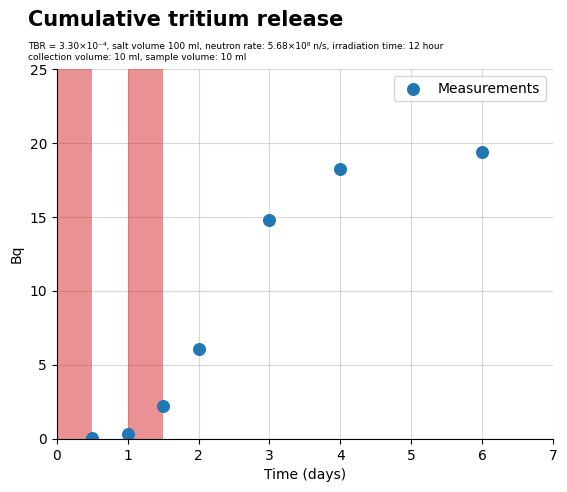

In [8]:
plt.figure()

# set x axis units to days
plt.gca().xaxis.set_units(ureg.day)

plot_model(
    model=baby_model,
    walls=False,
    top=False,
    replace_vials=False,
    title=False,
    detection_limit=None,
    linelabel=True,
)
print(replacement_times)
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=25 * ureg.Bq)
plt.xlim(right=7 * ureg.day)
plt.xlabel("Time (days)")
plt.ylabel("Bq")
plt.savefig('baby_run_4/cumulative_tritium_release_experimental_only.svg')

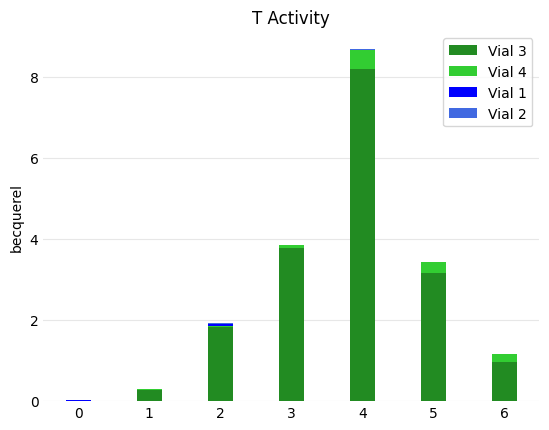

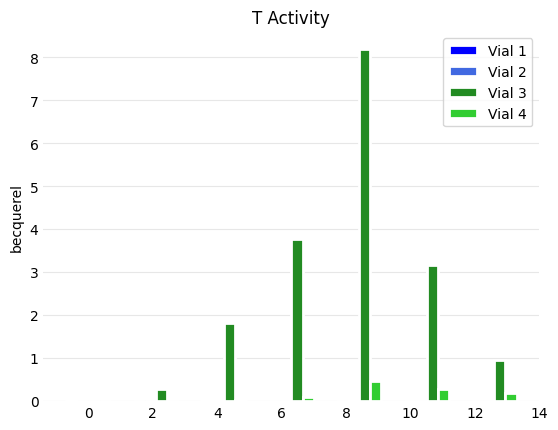

In [9]:
# Create the stacked bar plot
vial_1_vals = (
    np.array(
        [
            vial_421.magnitude,
            vial_431.magnitude,
            vial_441.magnitude,
            vial_451.magnitude,
            vial_461.magnitude,
            vial_471.magnitude,
            vial_481.magnitude,
        ]
    )
    * ureg.Bq
)

vial_2_vals = (
    np.array(
        [
            vial_422.magnitude,
            vial_432.magnitude,
            vial_442.magnitude,
            vial_452.magnitude,
            vial_462.magnitude,
            vial_472.magnitude,
            vial_482.magnitude,
        ]
    )
    * ureg.Bq
)

vial_3_vals = (
    np.array(
        [
            vial_423.magnitude,
            vial_433.magnitude,
            vial_443.magnitude,
            vial_453.magnitude,
            vial_463.magnitude,
            vial_473.magnitude,
            vial_483.magnitude,
        ]
    )
    * ureg.Bq
)

vial_4_vals = (
    np.array(
        [
            vial_424.magnitude,
            vial_434.magnitude,
            vial_444.magnitude,
            vial_454.magnitude,
            vial_464.magnitude,
            vial_474.magnitude,
            vial_484.magnitude,
        ]
    )
    * ureg.Bq
)

plt.figure()


def plot_bars(index=None, bar_width=0.35, stacked=True):
    if index is None:
        if stacked:
            index = np.arange(7)
        else:
            group_spacing = 1  # Adjust this value to control spacing between groups
            index = np.arange(7) * (group_spacing / 2 + 1) * bar_width * 4

    if stacked:
        vial_3_bar = plt.bar(
            index, vial_3_vals, bar_width, label="Vial 3", color="forestgreen"
        )
        vial_4_bar = plt.bar(
            index,
            vial_4_vals,
            bar_width,
            label="Vial 4",
            color="limegreen",
            bottom=vial_3_vals,
        )
        vial_1_bar = plt.bar(
            index,
            vial_1_vals,
            bar_width,
            label="Vial 1",
            color="blue",
            bottom=vial_3_vals + vial_4_vals,
        )
        vial_2_bar = plt.bar(
            index,
            vial_2_vals,
            bar_width,
            label="Vial 2",
            color="royalblue",
            bottom=vial_3_vals + vial_4_vals + vial_1_vals,
        )
    else:
        vial_1_bar = plt.bar(
            index - 1.5 * bar_width,
            vial_1_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 1",
            color="blue",
        )
        vial_2_bar = plt.bar(
            index - 0.5 * bar_width,
            vial_2_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 2",
            color="royalblue",
        )
        vial_3_bar = plt.bar(
            index + 0.5 * bar_width,
            vial_3_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 3",
            color="forestgreen",
        )
        vial_4_bar = plt.bar(
            index + 1.5 * bar_width,
            vial_4_vals,
            bar_width,
            linewidth=2,
            edgecolor="white",
            label="Vial 4",
            color="limegreen",
        )

    return index


for stacked in [True, False]:
    index = plot_bars(stacked=stacked)
    # plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_4/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_4/LSC results.svg")
    plt.gca().set_axisbelow(True)
    plt.show()

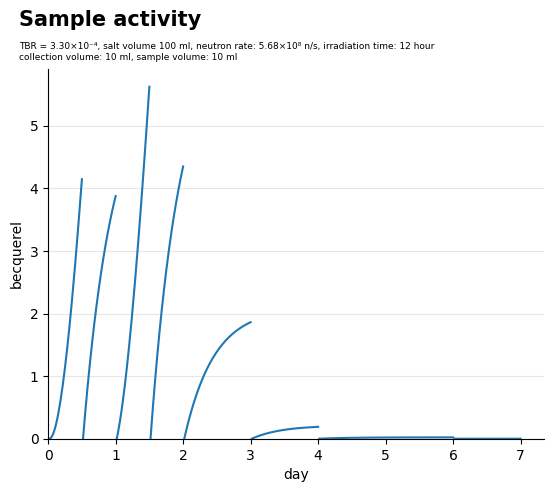

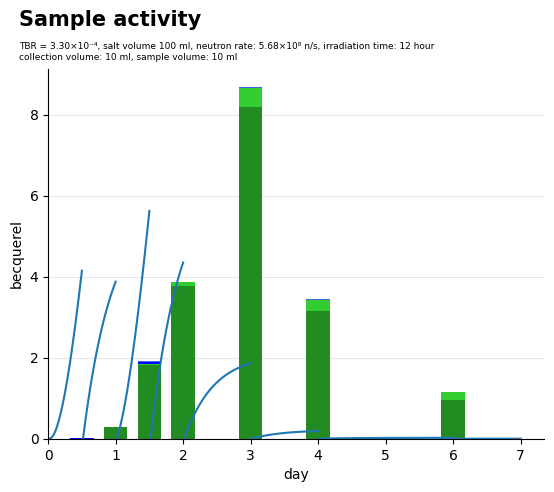

In [10]:
plt.figure()
plot_model(
    model=baby_model,
    replace_vials=replacement_times,
    walls=False,
    irradiation=False,
    detection_limit=None,
    linelabel=False,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_4/sample_activity_no_exp.svg")

plt.figure()
plot_bars(index=[time.to(ureg.day) for time in replacement_times])
plot_model(
    model=baby_model,
    replace_vials=replacement_times,
    walls=False,
    irradiation=False,
    detection_limit=None,
    linelabel=False,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_4/sample_activity.svg")


(0.0, 25.0)

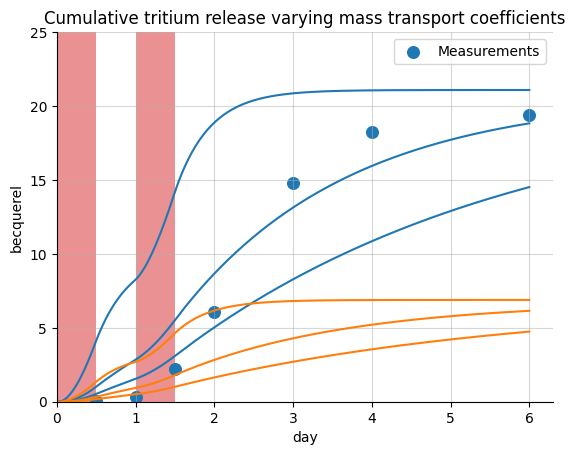

In [11]:
for i, mass_transport_coeff_factor2 in enumerate([0.1, 0.2, 1]):
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
    )

    new_baby_model.k_top *= mass_transport_coeff_factor * mass_transport_coeff_factor2
    new_baby_model.k_wall *= mass_transport_coeff_factor * mass_transport_coeff_factor2

    new_baby_model.number_days = baby_model.number_days
    new_baby_model.exposure_time = baby_model.exposure_time
    new_baby_model.neutron_rate = baby_model.neutron_rate
    new_baby_model.dt = baby_model.dt
    new_baby_model.run(6 * ureg.day)
    if i == 0:
        irradiation = True
    else:
        irradiation = False
    plot_model(
        new_baby_model,
        detection_limit=None,
        linelabel=False,
        title=False,
        subtitle=False,
        replace_vials=False,
        irradiation=irradiation,
    )
plt.title("Cumulative tritium release varying mass transport coefficients")
s = plt.scatter(
    replacement_times,
    cumulative_values,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.ylim(top=25 * ureg.Bq)

## Potential experimental plan for next run

In [12]:
new_baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=baby_model.TBR,
)

new_baby_model.k_top = baby_model.k_top
new_baby_model.k_wall = baby_model.k_wall

exposure_time = 3 * ureg.hour
resting_time = 0.5 * ureg.hour
cycle_time = exposure_time + resting_time
irradiations = []
for day in range(2):
    irradiations.append([day * ureg.day, day * ureg.day + exposure_time])
    while irradiations[-1][-1] + cycle_time < day * ureg.day + 12 * ureg.hour:
        irradiation_start = irradiations[-1][-1] + resting_time
        irradiation_stop = irradiation_start + exposure_time
        irradiations.append([irradiation_start, irradiation_stop])
new_baby_model.irradiations = irradiations
new_baby_model.neutron_rate = baby_model.neutron_rate
new_baby_model.dt = baby_model.dt
new_baby_model.run(6 * ureg.day)


In [13]:
replacement_times = [
    irr[0] for irr in new_baby_model.irradiations[1:]
]  # before each irradiation
replacement_times.append(3 * cycle_time)  # after the third cycle of day 1
replacement_times.append(
    1 * ureg.day + 3 * cycle_time
)  # after the third cycle of day 2

avg_background = (background_1 + background_2) / 2

plot_model(
    new_baby_model,
    irradiation=new_baby_model.irradiations,
    replace_vials=replacement_times,
    walls=False,
    detection_limit=avg_background,
    subtitle=False,
)
plt.figure()
plot_model(
    new_baby_model,
    irradiation=new_baby_model.irradiations,
    replace_vials=False,
    walls=False,
    detection_limit=None,
    subtitle=False,
    title=False,
)


NameError: name 'background_1' is not defined